## **Import Libraries**

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

# **Stage 1**

## **Data Setup & Preview** 

In [3]:
data_path = Path.home()/'notebooks/programming/data/watch_bot'
csv_path = Path.home()/'notebooks/programming/projects/watch_bot/data_prep/file_attribs.csv'

In [4]:
df = pd.read_csv(csv_path)
df = df[['name', 'dial_visibility']]
df = df.astype({'dial_visibility':'int'})
df.head(), df.dtypes

(                                                name  dial_visibility
 0  nomos_1/nomos/_without_model/nomos_@_the_loupe...                1
 1  nomos_1/nomos/_without_model/nomos_@_the_loupe...                1
 2  nomos_1/nomos/_without_model/nomos_@_the_loupe...                0
 3  nomos_1/nomos/_without_model/nomos_beta_11156_...                1
 4  nomos_1/nomos/_without_model/nomos_beta_11156_...                1,
 name               object
 dial_visibility     int64
 dtype: object)

In [5]:
bs = 64
img_size = 128
xform = get_transforms(flip_vert=True)

In [6]:
src = (ImageList.from_df(df, data_path)
        .split_by_rand_pct()
        .label_from_df())

In [7]:
data = (src.transform(tfms=xform, size=img_size, padding_mode='border')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [8]:
print(f'{data.train_ds}\n\n{data.valid_ds}')


LabelList (9579 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,1,0,1,0
Path: /home/neronicolo/notebooks/programming/data/watch_bot

LabelList (2394 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,1,1,0,1
Path: /home/neronicolo/notebooks/programming/data/watch_bot


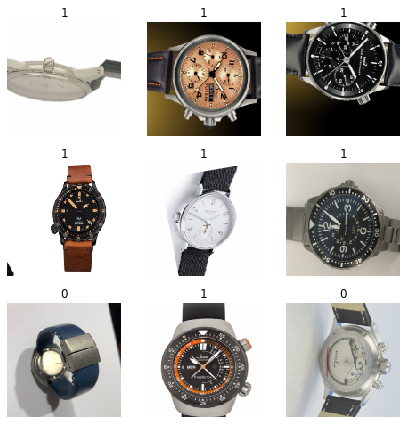

In [9]:
data.show_batch(rows=3, figsize=(6,6))

In [110]:
# TODO: resize before training - https://docs.fast.ai/vision.transform.html#resize
# look at https://nbviewer.jupyter.org/github/rsomani95/shot-type-classifier/blob/master/methodology.ipynb#Defining-Data-Transformations----

## **Training**

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy])
learn = learn.to_fp16()

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


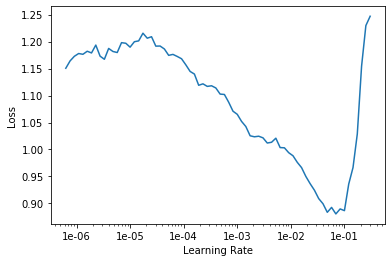

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(8, slice(1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.853822,0.466308,0.802423,01:16
1,0.614599,0.322917,0.862991,01:09
2,0.449007,0.216591,0.922723,01:09
3,0.362395,0.194155,0.931078,01:08
4,0.307654,0.159988,0.946533,01:09
5,0.272148,0.143971,0.950292,01:09
6,0.260186,0.134076,0.953634,01:08
7,0.255006,0.154975,0.947786,01:09


In [16]:
learn.save('stage_1')

## **Interpreting**

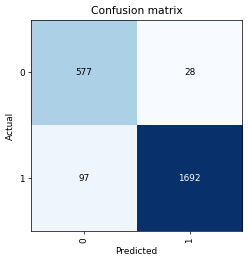

In [23]:
learn.load('stage_1')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi=64)

In [27]:
losses, idxs = interp.top_losses()
len(losses) == len(idxs) == len(data.valid_ds)

True

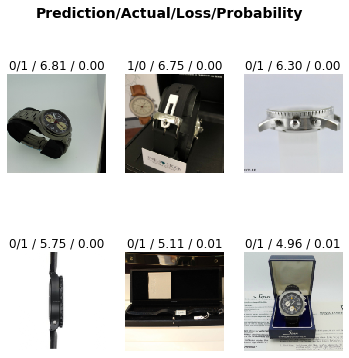

In [35]:
interp.plot_top_losses(6, figsize=(6,6))

## **Fine Tuning**

In [37]:
learn.load('stage_1');

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


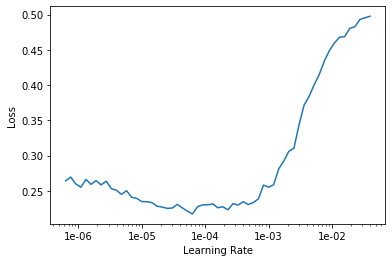

In [40]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(8, slice(1e-06, 3e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.232070,0.128100,0.952799,01:23
1,0.205487,0.133149,0.958229,01:23
2,0.168009,0.088214,0.971178,01:23
3,0.107874,0.083724,0.974102,01:23
4,0.091980,0.083873,0.975773,01:24
5,0.066573,0.074924,0.979114,01:24
6,0.061256,0.072086,0.979114,01:24
7,0.045557,0.069232,0.979114,01:24


In [42]:
learn.save('stage_1_fine_tuning')

## **Interpreting**

In [44]:
learn.load('stage_1_fine_tuning');

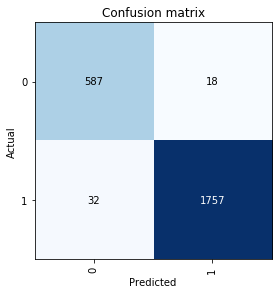

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

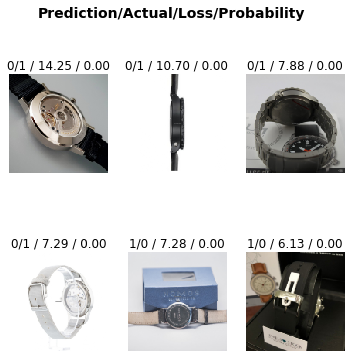

In [50]:
interp.plot_top_losses(6, figsize=(6,6))